<a href="https://colab.research.google.com/github/DanieleFoscarin/NNDL_hw2/blob/main/nndl_2020__homework_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


# Homework 2 - Unsupervised Deep Learning

## General overview
In this homework you will learn how to implement and test neural network models for solving unsupervised problems. For simplicity and to allow continuity with the kind of data you have seen before, the homework will be based on images of handwritten digits (MNIST). However, you can optionally explore different image collections (e.g., [Caltech](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) or [Cifar](https://www.cs.toronto.edu/~kriz/cifar.html)) or other datasets based on your interests. The basic tasks for the homework will require to test and analyze the convolutional autoencoder implemented during the Lab practice. If you prefer, you can opt for a fully-connected autoencoder, which should achieve similar performance considering the relatively small size of the MNIST images. As for the previous homework, you should explore the use of advanced optimizers and regularization methods. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. More advanced tasks will require the exploration of denoising and variational architectures.



## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework. If your code will be entirely included in a single Python notebook, just upload the notebook file.




## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length must not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional).




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	1 pt: implement and test (convolutional) autoencoder, reporting the trend of reconstruction loss and some examples of image reconstruction
*	1 pt: explore advanced optimizers and regularization methods 
*	1 pt: optimize hyperparameters using grid/random search and cross-validation
*	1 pt: implement and test denoising (convolutional) autoencoder
*	1 pt: fine-tune the (convolutional) autoencoder using a supervised classification task (you can compare classification accuracy and learning speed with results achieved in homework 1)
*	1 pt: explore the latent space structure (e.g., PCA, t-SNE) and generate new samples from latent codes
*	2 pt: implement variational (convolutional) autoencoder or GAN




## Deadline
The complete homework (source code + report) must be submitted through Moodle at least 10 days before the chosen exam date.

#################################################################

In [2]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms
import torchvision

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")
torch.manual_seed(0)

Training device: cuda



# Dataset






get notMNIST dataset from repo
It is the small version

In [3]:
! git clone https://github.com/DanieleFoscarin/NNDL_hw2.git

Cloning into 'NNDL_hw2'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 51 (delta 22), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (51/51), done.


In [4]:
! tar xzf  /content/NNDL_hw2/notMNIST_small.tar.gz

In [44]:
ROOT = '/content/notMNIST_small' 
from pathlib import Path
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

images = []
labels = []

#there are few broken files that cannot be read
#not a big problem since they are 5 over 500k
num_label = 0
for folder in sorted(Path(ROOT).iterdir()):
  print(folder)
  for f in folder.iterdir():
    try:     
      img = Image.open(f)
      img_array = np.asarray(img)
      images.append(img_array)
      labels.append(num_label)
    except:
      print("a file was not recognized")
  num_label+=1


images_arr = np.float32(np.array(images))
labels_arr = np.float32(np.array(labels))

#normalize images range
images_arr = images_arr/255
#free up some memory
del images

# #split dataset for classification purposes if needed
# X_train, X_test, y_train, y_test = train_test_split(images_arr, labels_arr, test_size=0.10, random_state=42)

# print(np.shape(X_train),' ', np.shape(y_train),' ', np.shape(X_test),' ', np.shape(y_test))

/content/notMNIST_small/A
a file was not recognized
/content/notMNIST_small/B
/content/notMNIST_small/C
/content/notMNIST_small/D
/content/notMNIST_small/E
/content/notMNIST_small/F
a file was not recognized
/content/notMNIST_small/G
/content/notMNIST_small/H
/content/notMNIST_small/I
/content/notMNIST_small/J


Dictionary for easy interpreation of the labels

In [6]:
letter = {0: 'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H', 8:'I', 9:'J'}
# print(letter[6])

In [45]:
#not sure the transformation is done correctly
class NMDataset(Dataset):

    def __init__(self, image, label, transform=None):
        self.transform = transform
        self.image = image
        self.label = label

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        #return a nparray from the dataframe
        this_image = self.image[idx]
        this_label = self.label[idx]
        sample = [this_image, this_label]
        if self.transform:
            sample[0] = self.transform(sample[0])
        return sample


    class ToTensor(object):
        """Convert sample to Tensors."""

        def __call__(self, sample):
            x, y = sample
            return (torch.tensor([x]).float(),
                    torch.tensor([y]).float())

to_tensor = torchvision.transforms.ToTensor()   
# composed_transform = transforms.Compose([ToTensor()])
dataset = NMDataset(images_arr, labels_arr, transform=to_tensor)

#check correctness
out = dataset.__getitem__(0)
print(labels_arr[0])
print(out[0])

0.0
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0078, 0.0000, 0.2941, 0.6824, 0.8627, 0.6824, 0.0000,
          0.0000, 0.0039, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0078, 0.0000, 0.1333, 0.9137, 1.0000, 1.0000, 0.8706, 0.0471,
          0.0000, 0.0039, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0039, 0.0078, 0.7176, 1.0000, 0.7216, 0.9843, 0.9961, 0.1373,
          0.0000, 0.0078, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0118,
          0.0000, 0.4745, 1.0000, 0.7294, 0.1373, 0.9

Split dataset in train, validation, test

In [46]:
length = dataset.__len__()
testval_size = int(np.ceil(length*0.4))
train_size = int(length-testval_size)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, testval_size])

test_size = int(np.ceil(test_dataset.__len__()*0.5))
val_size = int(test_dataset.__len__()-test_size)
test_dataset, val_dataset = torch.utils.data.random_split(test_dataset, [test_size, val_size])

print(f"train_dataset length {train_dataset.__len__()}")
print(f"val_dataset length {val_dataset.__len__()}")
print(f"test_dataset length {test_dataset.__len__()}")
# train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_dataset length 11234
val_dataset length 3745
test_dataset length 3745


It works with mnist mmmmh

In [33]:
#just to check database functions
# to_tensor = torchvision.transforms.ToTensor()
# data_dir = 'dataset'
# train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=to_tensor)
# test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=to_tensor)

Show example of the dataset

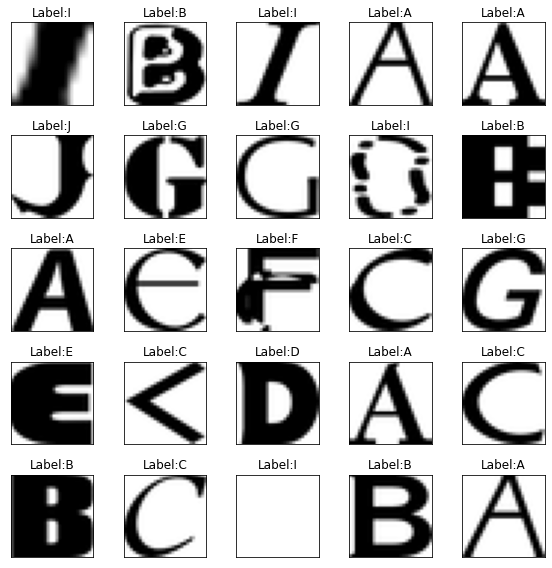

In [47]:
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    img, label = random.choice(test_dataset)
    img = img.numpy().squeeze()
    ax.imshow(np.array(img), cmap='gray_r')
    ax.set_title(f'Label:{letter[label]}' )
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

# Autoencoder Model Classes

same as the lab for now

In [11]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * 32, 64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(64, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [12]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(64, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

# Training preparation

need to make grid search here

In [49]:
batch_size = 256    #it will be integrated in grid search

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


In [50]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
encoded_space_dim = 3
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

In [51]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 1e-3 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

function for a single epoch training

In [52]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))

function for a single epoch inference

In [53]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [54]:

# img, label = test_dataset[0]
# print(np.shape(img))
# print(letter[label])

Training loop

EPOCH 1/40
	 partial train loss (single batch): 0.213971
	 partial train loss (single batch): 0.215627
	 partial train loss (single batch): 0.214433
	 partial train loss (single batch): 0.216466
	 partial train loss (single batch): 0.214238
	 partial train loss (single batch): 0.214073
	 partial train loss (single batch): 0.213468
	 partial train loss (single batch): 0.213573
	 partial train loss (single batch): 0.214786
	 partial train loss (single batch): 0.215475
	 partial train loss (single batch): 0.211959
	 partial train loss (single batch): 0.214801
	 partial train loss (single batch): 0.214246
	 partial train loss (single batch): 0.213759
	 partial train loss (single batch): 0.215060
	 partial train loss (single batch): 0.213596
	 partial train loss (single batch): 0.214016
	 partial train loss (single batch): 0.213834
	 partial train loss (single batch): 0.213101
	 partial train loss (single batch): 0.214259
	 partial train loss (single batch): 0.213848
	 partial train loss (s

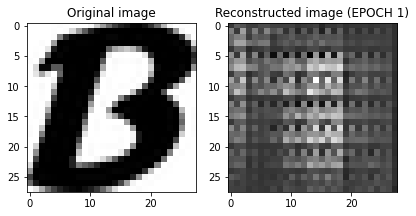

EPOCH 2/40
	 partial train loss (single batch): 0.204860
	 partial train loss (single batch): 0.207138
	 partial train loss (single batch): 0.207162
	 partial train loss (single batch): 0.205513
	 partial train loss (single batch): 0.203770
	 partial train loss (single batch): 0.200072
	 partial train loss (single batch): 0.201477
	 partial train loss (single batch): 0.202915
	 partial train loss (single batch): 0.205372
	 partial train loss (single batch): 0.200516
	 partial train loss (single batch): 0.197893
	 partial train loss (single batch): 0.196040
	 partial train loss (single batch): 0.198412
	 partial train loss (single batch): 0.199188
	 partial train loss (single batch): 0.194887
	 partial train loss (single batch): 0.195762
	 partial train loss (single batch): 0.196190
	 partial train loss (single batch): 0.194111
	 partial train loss (single batch): 0.190504
	 partial train loss (single batch): 0.189457
	 partial train loss (single batch): 0.191171
	 partial train loss (s

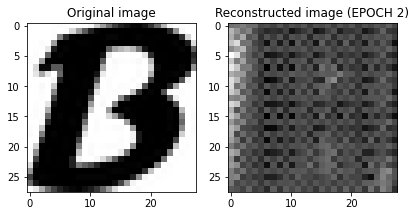

EPOCH 3/40
	 partial train loss (single batch): 0.183951
	 partial train loss (single batch): 0.179530
	 partial train loss (single batch): 0.179244
	 partial train loss (single batch): 0.179801
	 partial train loss (single batch): 0.183814
	 partial train loss (single batch): 0.183907
	 partial train loss (single batch): 0.186276
	 partial train loss (single batch): 0.181762
	 partial train loss (single batch): 0.182765
	 partial train loss (single batch): 0.180857
	 partial train loss (single batch): 0.180401
	 partial train loss (single batch): 0.176381
	 partial train loss (single batch): 0.181232
	 partial train loss (single batch): 0.182300
	 partial train loss (single batch): 0.175626
	 partial train loss (single batch): 0.177441
	 partial train loss (single batch): 0.176972
	 partial train loss (single batch): 0.173468
	 partial train loss (single batch): 0.171213
	 partial train loss (single batch): 0.167167
	 partial train loss (single batch): 0.167539
	 partial train loss (s

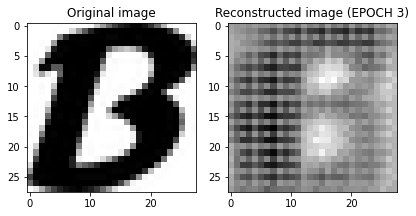

EPOCH 4/40
	 partial train loss (single batch): 0.135291
	 partial train loss (single batch): 0.133280
	 partial train loss (single batch): 0.133937
	 partial train loss (single batch): 0.129580
	 partial train loss (single batch): 0.128078
	 partial train loss (single batch): 0.124432
	 partial train loss (single batch): 0.130285
	 partial train loss (single batch): 0.127896
	 partial train loss (single batch): 0.125033
	 partial train loss (single batch): 0.128432
	 partial train loss (single batch): 0.126311
	 partial train loss (single batch): 0.125490
	 partial train loss (single batch): 0.125253
	 partial train loss (single batch): 0.120440
	 partial train loss (single batch): 0.121941
	 partial train loss (single batch): 0.127629
	 partial train loss (single batch): 0.125951
	 partial train loss (single batch): 0.123901
	 partial train loss (single batch): 0.122832
	 partial train loss (single batch): 0.120685
	 partial train loss (single batch): 0.122022
	 partial train loss (s

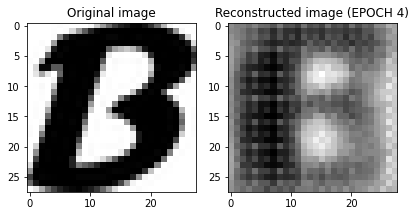

EPOCH 5/40
	 partial train loss (single batch): 0.111545
	 partial train loss (single batch): 0.118499
	 partial train loss (single batch): 0.113847
	 partial train loss (single batch): 0.117441
	 partial train loss (single batch): 0.116844
	 partial train loss (single batch): 0.117044
	 partial train loss (single batch): 0.114620
	 partial train loss (single batch): 0.117596
	 partial train loss (single batch): 0.111690
	 partial train loss (single batch): 0.110527
	 partial train loss (single batch): 0.117014
	 partial train loss (single batch): 0.116560
	 partial train loss (single batch): 0.118168
	 partial train loss (single batch): 0.123057
	 partial train loss (single batch): 0.116232
	 partial train loss (single batch): 0.113683
	 partial train loss (single batch): 0.109679
	 partial train loss (single batch): 0.113780
	 partial train loss (single batch): 0.112665
	 partial train loss (single batch): 0.111160
	 partial train loss (single batch): 0.111866
	 partial train loss (s

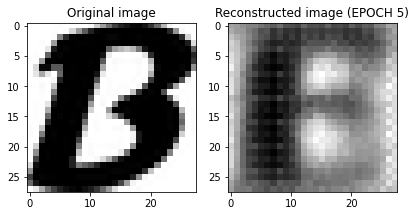

EPOCH 6/40
	 partial train loss (single batch): 0.109247
	 partial train loss (single batch): 0.105028
	 partial train loss (single batch): 0.108528
	 partial train loss (single batch): 0.110877
	 partial train loss (single batch): 0.109851
	 partial train loss (single batch): 0.114991
	 partial train loss (single batch): 0.115690
	 partial train loss (single batch): 0.110455
	 partial train loss (single batch): 0.110866
	 partial train loss (single batch): 0.109897
	 partial train loss (single batch): 0.113127
	 partial train loss (single batch): 0.109677
	 partial train loss (single batch): 0.109122
	 partial train loss (single batch): 0.108946
	 partial train loss (single batch): 0.112501
	 partial train loss (single batch): 0.109586
	 partial train loss (single batch): 0.112198
	 partial train loss (single batch): 0.108300
	 partial train loss (single batch): 0.109750
	 partial train loss (single batch): 0.112428
	 partial train loss (single batch): 0.104945
	 partial train loss (s

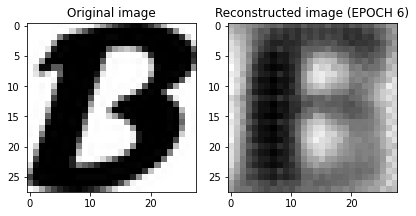

EPOCH 7/40
	 partial train loss (single batch): 0.109346
	 partial train loss (single batch): 0.111139
	 partial train loss (single batch): 0.110929
	 partial train loss (single batch): 0.109170
	 partial train loss (single batch): 0.104501
	 partial train loss (single batch): 0.108916
	 partial train loss (single batch): 0.108010
	 partial train loss (single batch): 0.107580
	 partial train loss (single batch): 0.109309
	 partial train loss (single batch): 0.108296
	 partial train loss (single batch): 0.108341
	 partial train loss (single batch): 0.105106
	 partial train loss (single batch): 0.112896
	 partial train loss (single batch): 0.114306
	 partial train loss (single batch): 0.105968
	 partial train loss (single batch): 0.110460
	 partial train loss (single batch): 0.111096
	 partial train loss (single batch): 0.109572
	 partial train loss (single batch): 0.109758
	 partial train loss (single batch): 0.107882
	 partial train loss (single batch): 0.104283
	 partial train loss (s

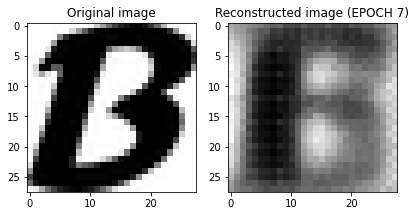

EPOCH 8/40
	 partial train loss (single batch): 0.107531
	 partial train loss (single batch): 0.109015
	 partial train loss (single batch): 0.103945
	 partial train loss (single batch): 0.107500
	 partial train loss (single batch): 0.107079
	 partial train loss (single batch): 0.105481
	 partial train loss (single batch): 0.108260
	 partial train loss (single batch): 0.102051
	 partial train loss (single batch): 0.109182
	 partial train loss (single batch): 0.107474
	 partial train loss (single batch): 0.101150
	 partial train loss (single batch): 0.106331
	 partial train loss (single batch): 0.109082
	 partial train loss (single batch): 0.110954
	 partial train loss (single batch): 0.110606
	 partial train loss (single batch): 0.102749
	 partial train loss (single batch): 0.106573
	 partial train loss (single batch): 0.103454
	 partial train loss (single batch): 0.103860
	 partial train loss (single batch): 0.103638
	 partial train loss (single batch): 0.106882
	 partial train loss (s

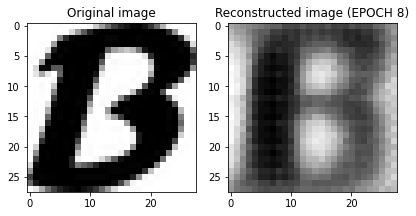

EPOCH 9/40
	 partial train loss (single batch): 0.100790
	 partial train loss (single batch): 0.111064
	 partial train loss (single batch): 0.106533
	 partial train loss (single batch): 0.101325
	 partial train loss (single batch): 0.099846
	 partial train loss (single batch): 0.104509
	 partial train loss (single batch): 0.105762
	 partial train loss (single batch): 0.103313
	 partial train loss (single batch): 0.103583
	 partial train loss (single batch): 0.104308
	 partial train loss (single batch): 0.098685
	 partial train loss (single batch): 0.104376
	 partial train loss (single batch): 0.110899
	 partial train loss (single batch): 0.107637
	 partial train loss (single batch): 0.108373
	 partial train loss (single batch): 0.108548
	 partial train loss (single batch): 0.108419
	 partial train loss (single batch): 0.104820
	 partial train loss (single batch): 0.104311
	 partial train loss (single batch): 0.097254
	 partial train loss (single batch): 0.105870
	 partial train loss (s

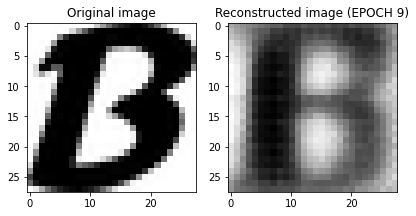

EPOCH 10/40
	 partial train loss (single batch): 0.101771
	 partial train loss (single batch): 0.107495
	 partial train loss (single batch): 0.104063
	 partial train loss (single batch): 0.103873
	 partial train loss (single batch): 0.101098
	 partial train loss (single batch): 0.103068
	 partial train loss (single batch): 0.102172
	 partial train loss (single batch): 0.105713
	 partial train loss (single batch): 0.104526
	 partial train loss (single batch): 0.107010
	 partial train loss (single batch): 0.107750
	 partial train loss (single batch): 0.099836
	 partial train loss (single batch): 0.101797
	 partial train loss (single batch): 0.099232
	 partial train loss (single batch): 0.107466
	 partial train loss (single batch): 0.100107
	 partial train loss (single batch): 0.105665
	 partial train loss (single batch): 0.101080
	 partial train loss (single batch): 0.100156
	 partial train loss (single batch): 0.100017
	 partial train loss (single batch): 0.097517
	 partial train loss (

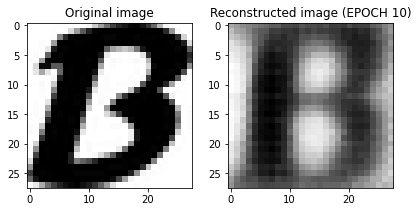

EPOCH 11/40
	 partial train loss (single batch): 0.092739
	 partial train loss (single batch): 0.104368
	 partial train loss (single batch): 0.099146
	 partial train loss (single batch): 0.101212
	 partial train loss (single batch): 0.104296
	 partial train loss (single batch): 0.092161
	 partial train loss (single batch): 0.106173
	 partial train loss (single batch): 0.099433
	 partial train loss (single batch): 0.097707
	 partial train loss (single batch): 0.100006
	 partial train loss (single batch): 0.101124
	 partial train loss (single batch): 0.103014
	 partial train loss (single batch): 0.099863
	 partial train loss (single batch): 0.099174
	 partial train loss (single batch): 0.102043
	 partial train loss (single batch): 0.101306
	 partial train loss (single batch): 0.108532
	 partial train loss (single batch): 0.096660
	 partial train loss (single batch): 0.100391
	 partial train loss (single batch): 0.101995
	 partial train loss (single batch): 0.099039
	 partial train loss (

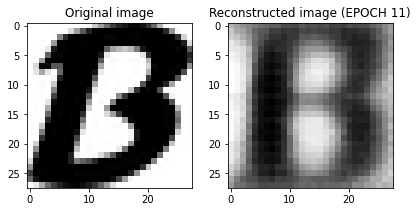

EPOCH 12/40
	 partial train loss (single batch): 0.100043
	 partial train loss (single batch): 0.097119
	 partial train loss (single batch): 0.098260
	 partial train loss (single batch): 0.100164
	 partial train loss (single batch): 0.098676
	 partial train loss (single batch): 0.103703
	 partial train loss (single batch): 0.094867
	 partial train loss (single batch): 0.096766
	 partial train loss (single batch): 0.095763
	 partial train loss (single batch): 0.098740
	 partial train loss (single batch): 0.105310
	 partial train loss (single batch): 0.102384
	 partial train loss (single batch): 0.100826
	 partial train loss (single batch): 0.098327
	 partial train loss (single batch): 0.105234
	 partial train loss (single batch): 0.097000
	 partial train loss (single batch): 0.093738
	 partial train loss (single batch): 0.102019
	 partial train loss (single batch): 0.095746
	 partial train loss (single batch): 0.100255
	 partial train loss (single batch): 0.099809
	 partial train loss (

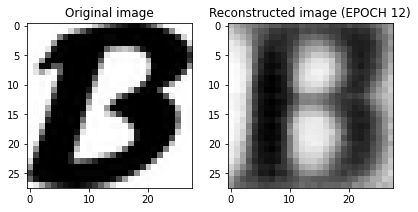

EPOCH 13/40
	 partial train loss (single batch): 0.091872
	 partial train loss (single batch): 0.095994
	 partial train loss (single batch): 0.102767
	 partial train loss (single batch): 0.098280
	 partial train loss (single batch): 0.103145
	 partial train loss (single batch): 0.096746
	 partial train loss (single batch): 0.101331
	 partial train loss (single batch): 0.097626
	 partial train loss (single batch): 0.094773
	 partial train loss (single batch): 0.097675
	 partial train loss (single batch): 0.093342
	 partial train loss (single batch): 0.097598
	 partial train loss (single batch): 0.094689
	 partial train loss (single batch): 0.101547
	 partial train loss (single batch): 0.093196
	 partial train loss (single batch): 0.093110
	 partial train loss (single batch): 0.094978
	 partial train loss (single batch): 0.100540
	 partial train loss (single batch): 0.100602
	 partial train loss (single batch): 0.100745
	 partial train loss (single batch): 0.100279
	 partial train loss (

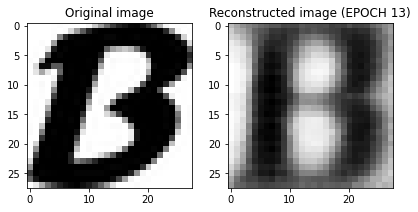

EPOCH 14/40
	 partial train loss (single batch): 0.098646
	 partial train loss (single batch): 0.095298
	 partial train loss (single batch): 0.095539
	 partial train loss (single batch): 0.099462
	 partial train loss (single batch): 0.093156
	 partial train loss (single batch): 0.094862
	 partial train loss (single batch): 0.101440
	 partial train loss (single batch): 0.095660
	 partial train loss (single batch): 0.093450
	 partial train loss (single batch): 0.097092
	 partial train loss (single batch): 0.094656
	 partial train loss (single batch): 0.096323
	 partial train loss (single batch): 0.097132
	 partial train loss (single batch): 0.093906
	 partial train loss (single batch): 0.096665
	 partial train loss (single batch): 0.096581
	 partial train loss (single batch): 0.095976
	 partial train loss (single batch): 0.092928
	 partial train loss (single batch): 0.096017
	 partial train loss (single batch): 0.103952
	 partial train loss (single batch): 0.100043
	 partial train loss (

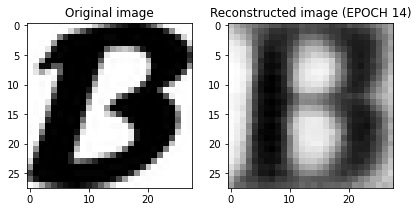

EPOCH 15/40
	 partial train loss (single batch): 0.093255
	 partial train loss (single batch): 0.091120
	 partial train loss (single batch): 0.099321
	 partial train loss (single batch): 0.097100
	 partial train loss (single batch): 0.092548
	 partial train loss (single batch): 0.096388
	 partial train loss (single batch): 0.097861
	 partial train loss (single batch): 0.097474
	 partial train loss (single batch): 0.093408
	 partial train loss (single batch): 0.091436
	 partial train loss (single batch): 0.095873
	 partial train loss (single batch): 0.087859
	 partial train loss (single batch): 0.094513
	 partial train loss (single batch): 0.102243
	 partial train loss (single batch): 0.095892
	 partial train loss (single batch): 0.095301
	 partial train loss (single batch): 0.098906
	 partial train loss (single batch): 0.098115
	 partial train loss (single batch): 0.093049
	 partial train loss (single batch): 0.100696
	 partial train loss (single batch): 0.099417
	 partial train loss (

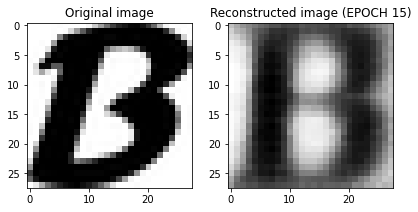

EPOCH 16/40
	 partial train loss (single batch): 0.097161
	 partial train loss (single batch): 0.098774
	 partial train loss (single batch): 0.096618
	 partial train loss (single batch): 0.097008
	 partial train loss (single batch): 0.094269
	 partial train loss (single batch): 0.091115
	 partial train loss (single batch): 0.093579
	 partial train loss (single batch): 0.095647
	 partial train loss (single batch): 0.092872
	 partial train loss (single batch): 0.096127
	 partial train loss (single batch): 0.093597
	 partial train loss (single batch): 0.092023
	 partial train loss (single batch): 0.094797
	 partial train loss (single batch): 0.095256
	 partial train loss (single batch): 0.096844
	 partial train loss (single batch): 0.101582
	 partial train loss (single batch): 0.087150
	 partial train loss (single batch): 0.094641
	 partial train loss (single batch): 0.097546
	 partial train loss (single batch): 0.089916
	 partial train loss (single batch): 0.095659
	 partial train loss (

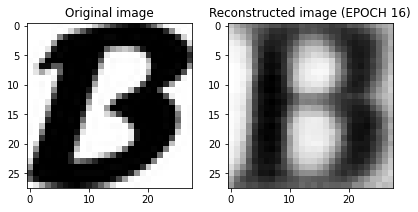

EPOCH 17/40
	 partial train loss (single batch): 0.092171
	 partial train loss (single batch): 0.094687
	 partial train loss (single batch): 0.095852
	 partial train loss (single batch): 0.093875
	 partial train loss (single batch): 0.093244
	 partial train loss (single batch): 0.092361
	 partial train loss (single batch): 0.097143
	 partial train loss (single batch): 0.093996
	 partial train loss (single batch): 0.099711
	 partial train loss (single batch): 0.093424
	 partial train loss (single batch): 0.093366
	 partial train loss (single batch): 0.090856
	 partial train loss (single batch): 0.086179
	 partial train loss (single batch): 0.089131
	 partial train loss (single batch): 0.097451
	 partial train loss (single batch): 0.089751
	 partial train loss (single batch): 0.096420
	 partial train loss (single batch): 0.088102
	 partial train loss (single batch): 0.091196
	 partial train loss (single batch): 0.091708
	 partial train loss (single batch): 0.093853
	 partial train loss (

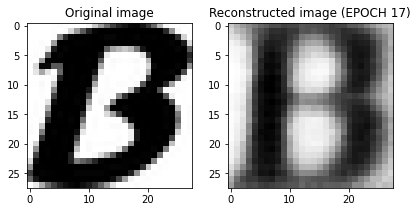

EPOCH 18/40
	 partial train loss (single batch): 0.089570
	 partial train loss (single batch): 0.090890
	 partial train loss (single batch): 0.087619
	 partial train loss (single batch): 0.092786
	 partial train loss (single batch): 0.097553
	 partial train loss (single batch): 0.093178
	 partial train loss (single batch): 0.095930
	 partial train loss (single batch): 0.091602
	 partial train loss (single batch): 0.093992
	 partial train loss (single batch): 0.094968
	 partial train loss (single batch): 0.091352
	 partial train loss (single batch): 0.090474
	 partial train loss (single batch): 0.093206
	 partial train loss (single batch): 0.094327
	 partial train loss (single batch): 0.090757
	 partial train loss (single batch): 0.085456
	 partial train loss (single batch): 0.096220
	 partial train loss (single batch): 0.094251
	 partial train loss (single batch): 0.092385
	 partial train loss (single batch): 0.096279
	 partial train loss (single batch): 0.092280
	 partial train loss (

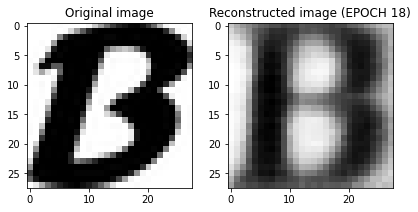

EPOCH 19/40
	 partial train loss (single batch): 0.091070
	 partial train loss (single batch): 0.096141
	 partial train loss (single batch): 0.089645
	 partial train loss (single batch): 0.093820
	 partial train loss (single batch): 0.095668
	 partial train loss (single batch): 0.094109
	 partial train loss (single batch): 0.089294
	 partial train loss (single batch): 0.092313
	 partial train loss (single batch): 0.085526
	 partial train loss (single batch): 0.092374
	 partial train loss (single batch): 0.093283
	 partial train loss (single batch): 0.093793
	 partial train loss (single batch): 0.090571
	 partial train loss (single batch): 0.090518
	 partial train loss (single batch): 0.089531
	 partial train loss (single batch): 0.091163
	 partial train loss (single batch): 0.092864
	 partial train loss (single batch): 0.092555
	 partial train loss (single batch): 0.088831
	 partial train loss (single batch): 0.091850
	 partial train loss (single batch): 0.089868
	 partial train loss (

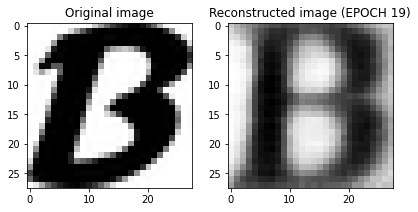

EPOCH 20/40
	 partial train loss (single batch): 0.094624
	 partial train loss (single batch): 0.090860
	 partial train loss (single batch): 0.090738
	 partial train loss (single batch): 0.088349
	 partial train loss (single batch): 0.091552
	 partial train loss (single batch): 0.093456
	 partial train loss (single batch): 0.094149
	 partial train loss (single batch): 0.091004
	 partial train loss (single batch): 0.089080
	 partial train loss (single batch): 0.089649
	 partial train loss (single batch): 0.088969
	 partial train loss (single batch): 0.088216
	 partial train loss (single batch): 0.088781
	 partial train loss (single batch): 0.090401
	 partial train loss (single batch): 0.095449
	 partial train loss (single batch): 0.093548
	 partial train loss (single batch): 0.093050
	 partial train loss (single batch): 0.090484
	 partial train loss (single batch): 0.088303
	 partial train loss (single batch): 0.090273
	 partial train loss (single batch): 0.092117
	 partial train loss (

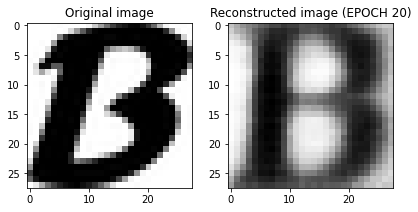

EPOCH 21/40
	 partial train loss (single batch): 0.086470
	 partial train loss (single batch): 0.086589
	 partial train loss (single batch): 0.090275
	 partial train loss (single batch): 0.090188
	 partial train loss (single batch): 0.088317
	 partial train loss (single batch): 0.093540
	 partial train loss (single batch): 0.094154
	 partial train loss (single batch): 0.089075
	 partial train loss (single batch): 0.088301
	 partial train loss (single batch): 0.091017
	 partial train loss (single batch): 0.092653
	 partial train loss (single batch): 0.090929
	 partial train loss (single batch): 0.085628
	 partial train loss (single batch): 0.088209
	 partial train loss (single batch): 0.092124
	 partial train loss (single batch): 0.087813
	 partial train loss (single batch): 0.086830
	 partial train loss (single batch): 0.091299
	 partial train loss (single batch): 0.092473
	 partial train loss (single batch): 0.088592
	 partial train loss (single batch): 0.094997
	 partial train loss (

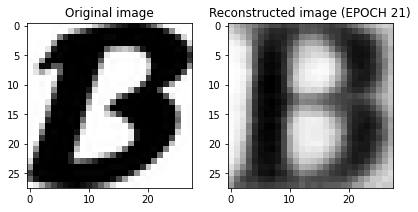

EPOCH 22/40
	 partial train loss (single batch): 0.094936
	 partial train loss (single batch): 0.089751
	 partial train loss (single batch): 0.092437
	 partial train loss (single batch): 0.094606
	 partial train loss (single batch): 0.088537
	 partial train loss (single batch): 0.091298
	 partial train loss (single batch): 0.088833
	 partial train loss (single batch): 0.091227
	 partial train loss (single batch): 0.093533
	 partial train loss (single batch): 0.089240
	 partial train loss (single batch): 0.089123
	 partial train loss (single batch): 0.089163
	 partial train loss (single batch): 0.086350
	 partial train loss (single batch): 0.092252
	 partial train loss (single batch): 0.090317
	 partial train loss (single batch): 0.088595
	 partial train loss (single batch): 0.087975
	 partial train loss (single batch): 0.086384
	 partial train loss (single batch): 0.088481
	 partial train loss (single batch): 0.092783
	 partial train loss (single batch): 0.088568
	 partial train loss (

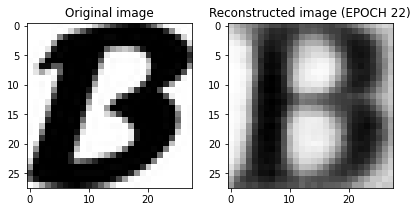

EPOCH 23/40
	 partial train loss (single batch): 0.088302
	 partial train loss (single batch): 0.094719
	 partial train loss (single batch): 0.086213
	 partial train loss (single batch): 0.090175
	 partial train loss (single batch): 0.085572
	 partial train loss (single batch): 0.087873
	 partial train loss (single batch): 0.091136
	 partial train loss (single batch): 0.085019
	 partial train loss (single batch): 0.086532
	 partial train loss (single batch): 0.090544
	 partial train loss (single batch): 0.085948
	 partial train loss (single batch): 0.095471
	 partial train loss (single batch): 0.091372
	 partial train loss (single batch): 0.093879
	 partial train loss (single batch): 0.096345
	 partial train loss (single batch): 0.093001
	 partial train loss (single batch): 0.088866
	 partial train loss (single batch): 0.086971
	 partial train loss (single batch): 0.085655
	 partial train loss (single batch): 0.087763
	 partial train loss (single batch): 0.088333
	 partial train loss (

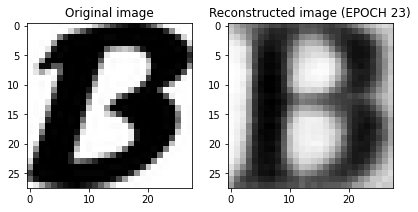

EPOCH 24/40
	 partial train loss (single batch): 0.084415
	 partial train loss (single batch): 0.087091
	 partial train loss (single batch): 0.087067
	 partial train loss (single batch): 0.089172
	 partial train loss (single batch): 0.086025
	 partial train loss (single batch): 0.088316
	 partial train loss (single batch): 0.089406
	 partial train loss (single batch): 0.085044
	 partial train loss (single batch): 0.093521
	 partial train loss (single batch): 0.089421
	 partial train loss (single batch): 0.086076
	 partial train loss (single batch): 0.089497
	 partial train loss (single batch): 0.088605
	 partial train loss (single batch): 0.089839
	 partial train loss (single batch): 0.094588
	 partial train loss (single batch): 0.084388
	 partial train loss (single batch): 0.087224
	 partial train loss (single batch): 0.092595
	 partial train loss (single batch): 0.089205
	 partial train loss (single batch): 0.088544
	 partial train loss (single batch): 0.088643
	 partial train loss (

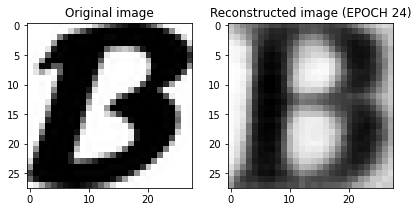

EPOCH 25/40
	 partial train loss (single batch): 0.089387
	 partial train loss (single batch): 0.092213
	 partial train loss (single batch): 0.092102
	 partial train loss (single batch): 0.086940
	 partial train loss (single batch): 0.088719
	 partial train loss (single batch): 0.089152
	 partial train loss (single batch): 0.089654
	 partial train loss (single batch): 0.094035
	 partial train loss (single batch): 0.083126
	 partial train loss (single batch): 0.085236
	 partial train loss (single batch): 0.087661
	 partial train loss (single batch): 0.090046
	 partial train loss (single batch): 0.089534
	 partial train loss (single batch): 0.089318
	 partial train loss (single batch): 0.092120
	 partial train loss (single batch): 0.084019
	 partial train loss (single batch): 0.086618
	 partial train loss (single batch): 0.083285
	 partial train loss (single batch): 0.090364
	 partial train loss (single batch): 0.088969
	 partial train loss (single batch): 0.089091
	 partial train loss (

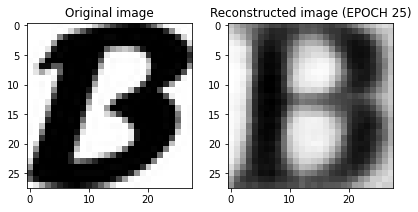

EPOCH 26/40
	 partial train loss (single batch): 0.089094
	 partial train loss (single batch): 0.088492
	 partial train loss (single batch): 0.087179
	 partial train loss (single batch): 0.087556
	 partial train loss (single batch): 0.088287
	 partial train loss (single batch): 0.084860
	 partial train loss (single batch): 0.091364
	 partial train loss (single batch): 0.088631
	 partial train loss (single batch): 0.088657
	 partial train loss (single batch): 0.088210
	 partial train loss (single batch): 0.091435
	 partial train loss (single batch): 0.093677
	 partial train loss (single batch): 0.091787
	 partial train loss (single batch): 0.090085
	 partial train loss (single batch): 0.083958
	 partial train loss (single batch): 0.086227
	 partial train loss (single batch): 0.083834
	 partial train loss (single batch): 0.087189
	 partial train loss (single batch): 0.083248
	 partial train loss (single batch): 0.087511
	 partial train loss (single batch): 0.087477
	 partial train loss (

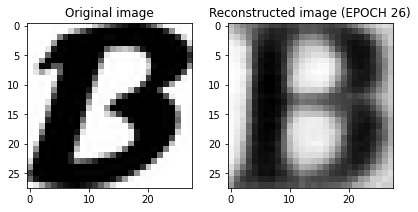

EPOCH 27/40
	 partial train loss (single batch): 0.083856
	 partial train loss (single batch): 0.089130
	 partial train loss (single batch): 0.087637
	 partial train loss (single batch): 0.089469
	 partial train loss (single batch): 0.090258
	 partial train loss (single batch): 0.089069
	 partial train loss (single batch): 0.088162
	 partial train loss (single batch): 0.087755
	 partial train loss (single batch): 0.087175
	 partial train loss (single batch): 0.088574
	 partial train loss (single batch): 0.086989
	 partial train loss (single batch): 0.092169
	 partial train loss (single batch): 0.089108
	 partial train loss (single batch): 0.087013
	 partial train loss (single batch): 0.086854
	 partial train loss (single batch): 0.084422
	 partial train loss (single batch): 0.087608
	 partial train loss (single batch): 0.084846
	 partial train loss (single batch): 0.092800
	 partial train loss (single batch): 0.090545
	 partial train loss (single batch): 0.086877
	 partial train loss (

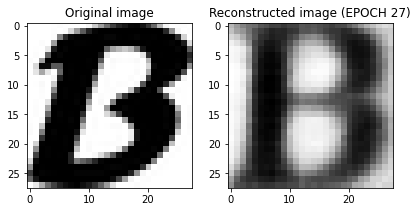

EPOCH 28/40
	 partial train loss (single batch): 0.084196
	 partial train loss (single batch): 0.088028
	 partial train loss (single batch): 0.087922
	 partial train loss (single batch): 0.091138
	 partial train loss (single batch): 0.087174
	 partial train loss (single batch): 0.086095
	 partial train loss (single batch): 0.082403
	 partial train loss (single batch): 0.085201
	 partial train loss (single batch): 0.088800
	 partial train loss (single batch): 0.081375
	 partial train loss (single batch): 0.091227
	 partial train loss (single batch): 0.092978
	 partial train loss (single batch): 0.090940
	 partial train loss (single batch): 0.092625
	 partial train loss (single batch): 0.087449
	 partial train loss (single batch): 0.089020
	 partial train loss (single batch): 0.084609
	 partial train loss (single batch): 0.086208
	 partial train loss (single batch): 0.083800
	 partial train loss (single batch): 0.093149
	 partial train loss (single batch): 0.081218
	 partial train loss (

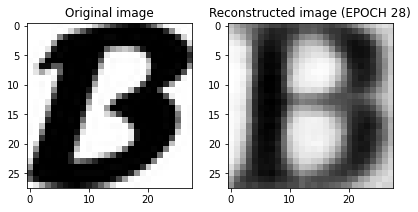

EPOCH 29/40
	 partial train loss (single batch): 0.083965
	 partial train loss (single batch): 0.089873
	 partial train loss (single batch): 0.085849
	 partial train loss (single batch): 0.090277
	 partial train loss (single batch): 0.090482
	 partial train loss (single batch): 0.085620
	 partial train loss (single batch): 0.082753
	 partial train loss (single batch): 0.088025
	 partial train loss (single batch): 0.089740
	 partial train loss (single batch): 0.084945
	 partial train loss (single batch): 0.089819
	 partial train loss (single batch): 0.086429
	 partial train loss (single batch): 0.089239
	 partial train loss (single batch): 0.088169
	 partial train loss (single batch): 0.087656
	 partial train loss (single batch): 0.083984
	 partial train loss (single batch): 0.085606
	 partial train loss (single batch): 0.090291
	 partial train loss (single batch): 0.083794
	 partial train loss (single batch): 0.092301
	 partial train loss (single batch): 0.088088
	 partial train loss (

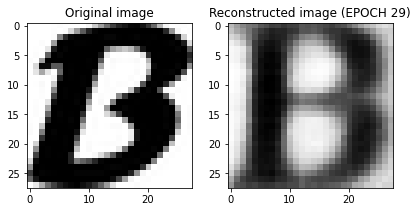

EPOCH 30/40
	 partial train loss (single batch): 0.088520
	 partial train loss (single batch): 0.089690
	 partial train loss (single batch): 0.087151
	 partial train loss (single batch): 0.087163
	 partial train loss (single batch): 0.084160
	 partial train loss (single batch): 0.086182
	 partial train loss (single batch): 0.087216
	 partial train loss (single batch): 0.088947
	 partial train loss (single batch): 0.088877
	 partial train loss (single batch): 0.085948
	 partial train loss (single batch): 0.090111
	 partial train loss (single batch): 0.088884
	 partial train loss (single batch): 0.086046
	 partial train loss (single batch): 0.088167
	 partial train loss (single batch): 0.085208
	 partial train loss (single batch): 0.078731
	 partial train loss (single batch): 0.089328
	 partial train loss (single batch): 0.086973
	 partial train loss (single batch): 0.087671
	 partial train loss (single batch): 0.091683
	 partial train loss (single batch): 0.080907
	 partial train loss (

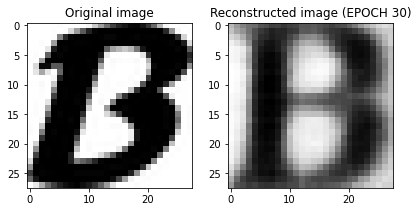

EPOCH 31/40
	 partial train loss (single batch): 0.080931
	 partial train loss (single batch): 0.084581
	 partial train loss (single batch): 0.082914
	 partial train loss (single batch): 0.089143
	 partial train loss (single batch): 0.088055
	 partial train loss (single batch): 0.083260
	 partial train loss (single batch): 0.092503
	 partial train loss (single batch): 0.087739
	 partial train loss (single batch): 0.088482
	 partial train loss (single batch): 0.088244
	 partial train loss (single batch): 0.089675
	 partial train loss (single batch): 0.092297
	 partial train loss (single batch): 0.079331
	 partial train loss (single batch): 0.089423
	 partial train loss (single batch): 0.083093
	 partial train loss (single batch): 0.090466
	 partial train loss (single batch): 0.085086
	 partial train loss (single batch): 0.088793
	 partial train loss (single batch): 0.083497
	 partial train loss (single batch): 0.087285
	 partial train loss (single batch): 0.087076
	 partial train loss (

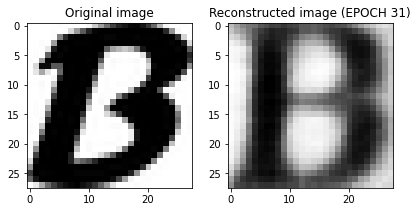

EPOCH 32/40
	 partial train loss (single batch): 0.091951
	 partial train loss (single batch): 0.087250
	 partial train loss (single batch): 0.089627
	 partial train loss (single batch): 0.089060
	 partial train loss (single batch): 0.091499
	 partial train loss (single batch): 0.080901
	 partial train loss (single batch): 0.085198
	 partial train loss (single batch): 0.086263
	 partial train loss (single batch): 0.086248
	 partial train loss (single batch): 0.084029
	 partial train loss (single batch): 0.087382
	 partial train loss (single batch): 0.086146
	 partial train loss (single batch): 0.083278
	 partial train loss (single batch): 0.090970
	 partial train loss (single batch): 0.086686
	 partial train loss (single batch): 0.089048
	 partial train loss (single batch): 0.086118
	 partial train loss (single batch): 0.082923
	 partial train loss (single batch): 0.085215
	 partial train loss (single batch): 0.089237
	 partial train loss (single batch): 0.082555
	 partial train loss (

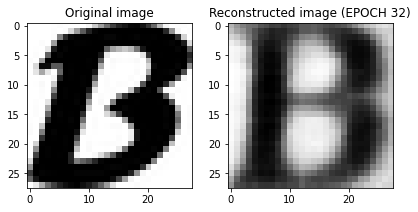

EPOCH 33/40
	 partial train loss (single batch): 0.087750
	 partial train loss (single batch): 0.083335
	 partial train loss (single batch): 0.079562
	 partial train loss (single batch): 0.093962
	 partial train loss (single batch): 0.083328
	 partial train loss (single batch): 0.089858
	 partial train loss (single batch): 0.083292
	 partial train loss (single batch): 0.093403
	 partial train loss (single batch): 0.086503
	 partial train loss (single batch): 0.089421
	 partial train loss (single batch): 0.086925
	 partial train loss (single batch): 0.083588
	 partial train loss (single batch): 0.084577
	 partial train loss (single batch): 0.085875
	 partial train loss (single batch): 0.090215
	 partial train loss (single batch): 0.091336
	 partial train loss (single batch): 0.086796
	 partial train loss (single batch): 0.082960
	 partial train loss (single batch): 0.086987
	 partial train loss (single batch): 0.084200
	 partial train loss (single batch): 0.080810
	 partial train loss (

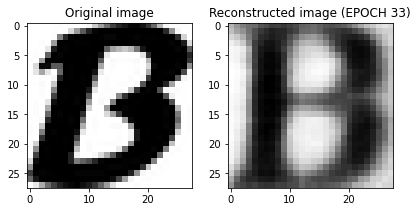

EPOCH 34/40
	 partial train loss (single batch): 0.088777
	 partial train loss (single batch): 0.085597
	 partial train loss (single batch): 0.083913
	 partial train loss (single batch): 0.085817
	 partial train loss (single batch): 0.086652
	 partial train loss (single batch): 0.088150
	 partial train loss (single batch): 0.083729
	 partial train loss (single batch): 0.083566
	 partial train loss (single batch): 0.088959
	 partial train loss (single batch): 0.087225
	 partial train loss (single batch): 0.084671
	 partial train loss (single batch): 0.090235
	 partial train loss (single batch): 0.085994
	 partial train loss (single batch): 0.081277
	 partial train loss (single batch): 0.088963
	 partial train loss (single batch): 0.084318
	 partial train loss (single batch): 0.086970
	 partial train loss (single batch): 0.086516
	 partial train loss (single batch): 0.085651
	 partial train loss (single batch): 0.088766
	 partial train loss (single batch): 0.088217
	 partial train loss (

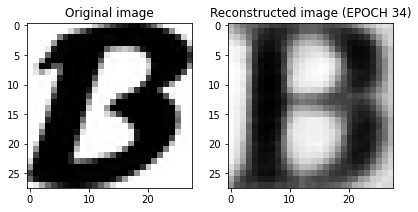

EPOCH 35/40
	 partial train loss (single batch): 0.081960
	 partial train loss (single batch): 0.083283
	 partial train loss (single batch): 0.085892
	 partial train loss (single batch): 0.092141
	 partial train loss (single batch): 0.083063
	 partial train loss (single batch): 0.088532
	 partial train loss (single batch): 0.083217
	 partial train loss (single batch): 0.086294
	 partial train loss (single batch): 0.089350
	 partial train loss (single batch): 0.084993
	 partial train loss (single batch): 0.080569
	 partial train loss (single batch): 0.090159
	 partial train loss (single batch): 0.085736
	 partial train loss (single batch): 0.081463
	 partial train loss (single batch): 0.091015
	 partial train loss (single batch): 0.084164
	 partial train loss (single batch): 0.082473
	 partial train loss (single batch): 0.088588
	 partial train loss (single batch): 0.084561
	 partial train loss (single batch): 0.086973
	 partial train loss (single batch): 0.083939
	 partial train loss (

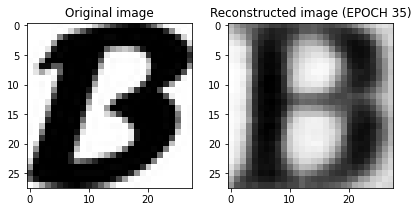

EPOCH 36/40
	 partial train loss (single batch): 0.087149
	 partial train loss (single batch): 0.080991
	 partial train loss (single batch): 0.086724
	 partial train loss (single batch): 0.080772
	 partial train loss (single batch): 0.083818
	 partial train loss (single batch): 0.086324
	 partial train loss (single batch): 0.080163
	 partial train loss (single batch): 0.083977
	 partial train loss (single batch): 0.085643
	 partial train loss (single batch): 0.087769
	 partial train loss (single batch): 0.085928
	 partial train loss (single batch): 0.082604
	 partial train loss (single batch): 0.088004
	 partial train loss (single batch): 0.084267
	 partial train loss (single batch): 0.086377
	 partial train loss (single batch): 0.081590
	 partial train loss (single batch): 0.089867
	 partial train loss (single batch): 0.086533
	 partial train loss (single batch): 0.081377
	 partial train loss (single batch): 0.084782
	 partial train loss (single batch): 0.086537
	 partial train loss (

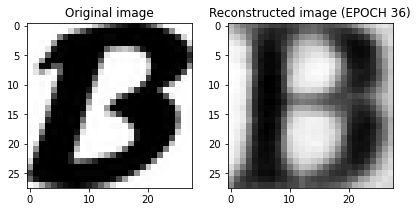

EPOCH 37/40
	 partial train loss (single batch): 0.083456
	 partial train loss (single batch): 0.080016
	 partial train loss (single batch): 0.085584
	 partial train loss (single batch): 0.085373
	 partial train loss (single batch): 0.081857
	 partial train loss (single batch): 0.080550
	 partial train loss (single batch): 0.085391
	 partial train loss (single batch): 0.089380
	 partial train loss (single batch): 0.083826
	 partial train loss (single batch): 0.078222
	 partial train loss (single batch): 0.088517
	 partial train loss (single batch): 0.085030
	 partial train loss (single batch): 0.082158
	 partial train loss (single batch): 0.082573
	 partial train loss (single batch): 0.083115
	 partial train loss (single batch): 0.086529
	 partial train loss (single batch): 0.086468
	 partial train loss (single batch): 0.078700
	 partial train loss (single batch): 0.088062
	 partial train loss (single batch): 0.083750
	 partial train loss (single batch): 0.085262
	 partial train loss (

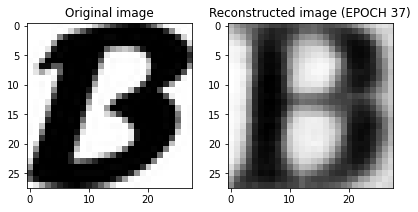

EPOCH 38/40
	 partial train loss (single batch): 0.091186
	 partial train loss (single batch): 0.085118
	 partial train loss (single batch): 0.080968
	 partial train loss (single batch): 0.084775
	 partial train loss (single batch): 0.082255
	 partial train loss (single batch): 0.083268
	 partial train loss (single batch): 0.085296
	 partial train loss (single batch): 0.083227
	 partial train loss (single batch): 0.084695
	 partial train loss (single batch): 0.083377
	 partial train loss (single batch): 0.089152
	 partial train loss (single batch): 0.077673
	 partial train loss (single batch): 0.080810
	 partial train loss (single batch): 0.086107
	 partial train loss (single batch): 0.084815
	 partial train loss (single batch): 0.087217
	 partial train loss (single batch): 0.081922
	 partial train loss (single batch): 0.086305
	 partial train loss (single batch): 0.080467
	 partial train loss (single batch): 0.088724
	 partial train loss (single batch): 0.086295
	 partial train loss (

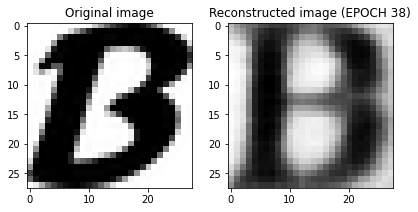

EPOCH 39/40
	 partial train loss (single batch): 0.085549
	 partial train loss (single batch): 0.080299
	 partial train loss (single batch): 0.082960
	 partial train loss (single batch): 0.083879
	 partial train loss (single batch): 0.084411
	 partial train loss (single batch): 0.082151
	 partial train loss (single batch): 0.085612
	 partial train loss (single batch): 0.084789
	 partial train loss (single batch): 0.083521
	 partial train loss (single batch): 0.085441
	 partial train loss (single batch): 0.082644
	 partial train loss (single batch): 0.088798
	 partial train loss (single batch): 0.082531
	 partial train loss (single batch): 0.081092
	 partial train loss (single batch): 0.088048
	 partial train loss (single batch): 0.086943
	 partial train loss (single batch): 0.082719
	 partial train loss (single batch): 0.090044
	 partial train loss (single batch): 0.079396
	 partial train loss (single batch): 0.087841
	 partial train loss (single batch): 0.082574
	 partial train loss (

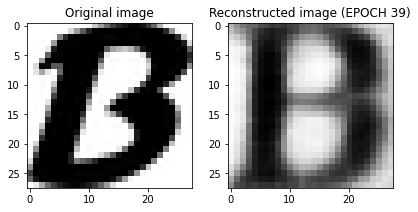

EPOCH 40/40
	 partial train loss (single batch): 0.086714
	 partial train loss (single batch): 0.087586
	 partial train loss (single batch): 0.081491
	 partial train loss (single batch): 0.083642
	 partial train loss (single batch): 0.090095
	 partial train loss (single batch): 0.083550
	 partial train loss (single batch): 0.085760
	 partial train loss (single batch): 0.083632
	 partial train loss (single batch): 0.087252
	 partial train loss (single batch): 0.090211
	 partial train loss (single batch): 0.086016
	 partial train loss (single batch): 0.086139
	 partial train loss (single batch): 0.083967
	 partial train loss (single batch): 0.084203
	 partial train loss (single batch): 0.077761
	 partial train loss (single batch): 0.086839
	 partial train loss (single batch): 0.084766
	 partial train loss (single batch): 0.079347
	 partial train loss (single batch): 0.083685
	 partial train loss (single batch): 0.081586
	 partial train loss (single batch): 0.081147
	 partial train loss (

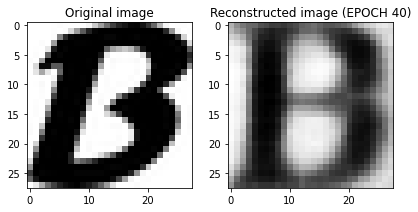

In [55]:
### Training cycle
num_epochs = 40
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    ### Validation  (use the testing function)
    val_loss = test_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=test_dataloader, 
        loss_fn=loss_fn)
    # Print Validationloss
    print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

    ### Plot progress
    # Get the output of a specific image (the test image at index 0 in this case)
    img = test_dataset[0][0].unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        rec_img  = decoder(encoder(img))
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(6,3))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gray_r')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gray_r')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)
    # Save figures
    os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
    fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
    plt.show()
    plt.close()

    # Save network parameters
    torch.save(encoder.state_dict(), 'encoder_params.pth')
    torch.save(decoder.state_dict(), 'decoder_params.pth')

    # NOTE: Remember to save also the parameters of the optimizer if you want to restore and continue the training